In [1]:
import tensorflow as tf
from vit import ViTClassfier
from utils import plot_grid_ds, AttrDict, BalancedSparseCategoricalAccuracy

In [2]:
hparams = AttrDict(
    image_size=(64, 64, 3),
    n_classes=4,
    batch_size=64,
)

ds = tf.keras.preprocessing.image_dataset_from_directory("dataset", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)
train_split = round(0.8 * ds.cardinality().numpy()) 
train_ds = ds.take(train_split); train_ds.class_names = ds.class_names
validation_ds = ds.skip(train_split); validation_ds.class_names = ds.class_names

Found 3265 files belonging to 4 classes.


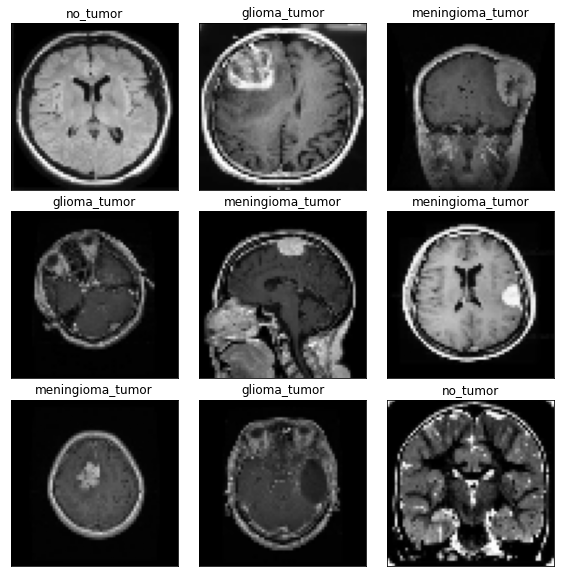

In [3]:
_ = plot_grid_ds(train_ds)

In [4]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = ViTClassfier(hparams.image_size, hparams.n_classes)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [5]:
model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
42/42 [==============================] - 17s 250ms/step - loss: 4.7778 - accuracy: 0.3761 - balanced_sparse_categorical_accuracy: 0.3637 - val_loss: 0.8953 - val_a

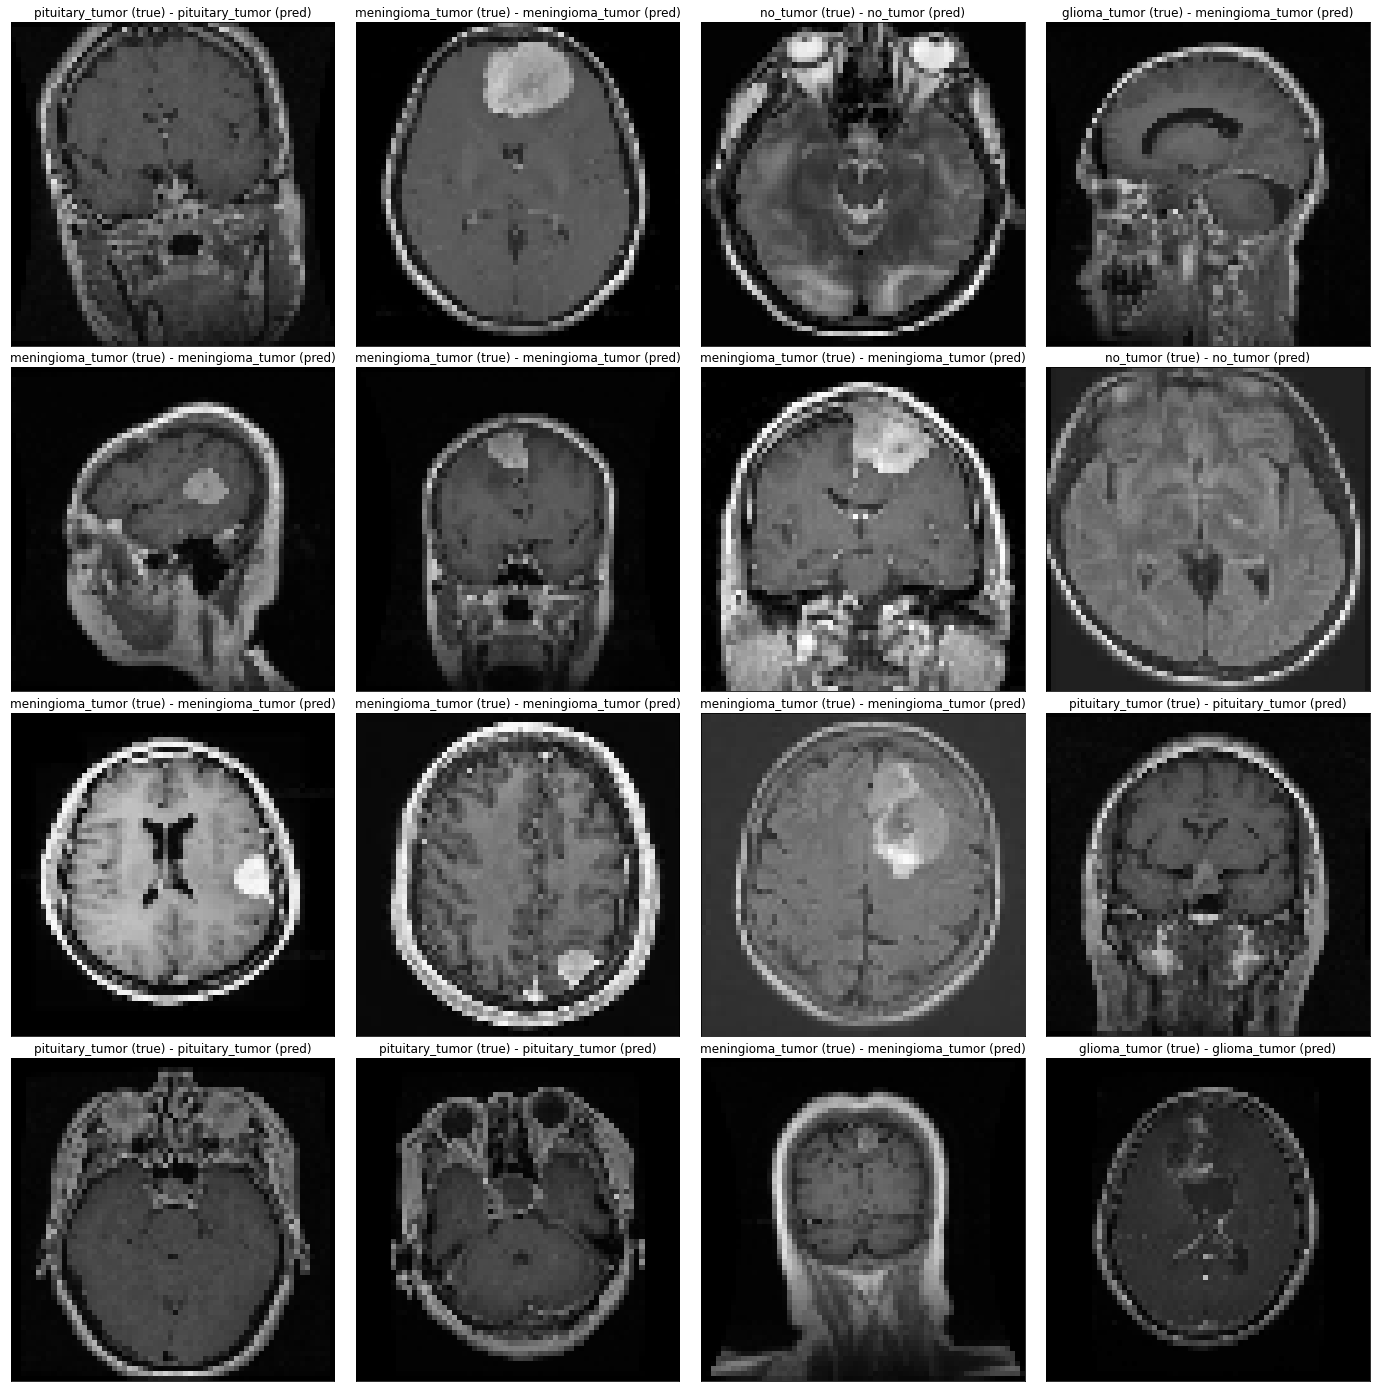

In [8]:
_ = plot_grid_ds(validation_ds, size=(4, 4), model=model, figsize=(25, 25))

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix

X, y_true = list(zip(*[(X, y) for (X, y) in validation_ds.unbatch().as_numpy_iterator()]))
y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
mat = confusion_matrix(y_true, y_hat)
mat

array([[165,   7,   0,   1],
       [ 12, 156,   1,   2],
       [  0,   2,  73,   2],
       [  0,   0,   0, 156]])

In [10]:
from sklearn.metrics import balanced_accuracy_score

acc = balanced_accuracy_score(y_true, y_hat)
print(f"Final accuracy on validation set : {acc:.3f}")

Final accuracy on validation set : 0.954


In [12]:
model.save("models/ViT_on_10_epochs.model")